In [1]:
import torch
print(torch.version.cuda)
print(torch.cuda.is_available())

11.8
True


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader
import torchvision.models as models
from torch import nn, optim
import random
print(torch.cuda.is_available())

True


In [3]:
# Get the current directory
current_directory = os.getcwd()
print("Current Directory:", current_directory) 

# Change the directory to the new path
new_directory = r"C:\Users\Razer\Documents\pytorch"
os.chdir(new_directory)
print("Changed to Directory:", os.getcwd())

# Check if CUDA (GPU support) is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Current Directory: c:\Users\Razer\Downloads
Changed to Directory: C:\Users\Razer\Documents\pytorch
Using device: cuda


Using device: cuda
Total number of valid images in the bad dataset after removing NaN values: 1629
Total number of valid images in the good dataset after removing NaN values: 291
Total number of valid images in the bad dataset after removing NaN values: 531
Total number of valid images in the good dataset after removing NaN values: 97
Total number of valid images in the training dataset: 1920
Total number of valid images in the test dataset: 628
Saved: C:\Users\Razer\DeepSPM\classifier\FYP complete dataset\transformed_train\bad\1000_Bad_Default_transformed.npy and C:\Users\Razer\DeepSPM\classifier\FYP complete dataset\transformed_train\bad\1000_Bad_Default_original.npy
Saved: C:\Users\Razer\DeepSPM\classifier\FYP complete dataset\transformed_train\bad\1002_Bad_Default_transformed.npy and C:\Users\Razer\DeepSPM\classifier\FYP complete dataset\transformed_train\bad\1002_Bad_Default_original.npy
Saved: C:\Users\Razer\DeepSPM\classifier\FYP complete dataset\transformed_train\bad\1003_Bad_D

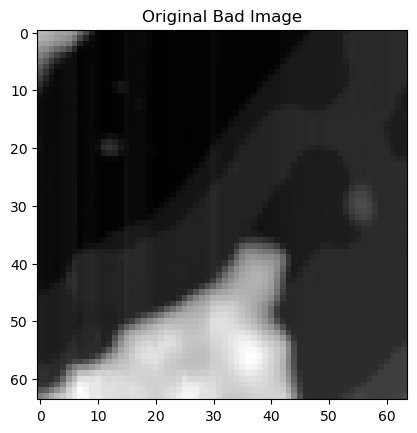

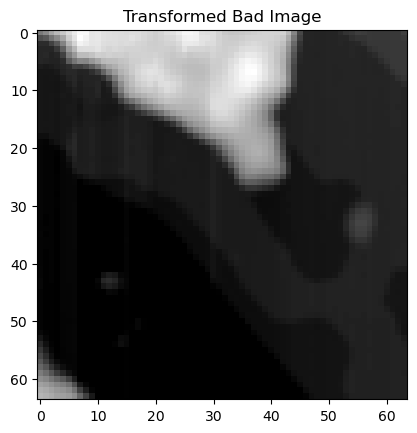

Good Sample 1630:
Label: 1
Transformed Image shape: (1, 64, 64)
Pixel value range: -1.0 - 0.9921568632125854


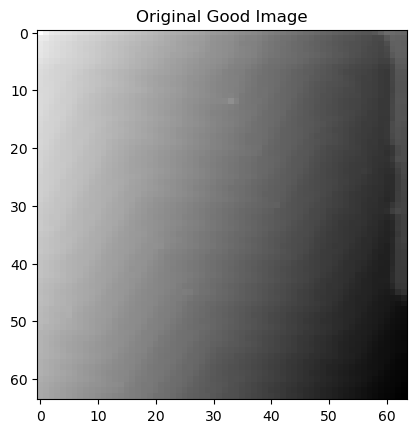

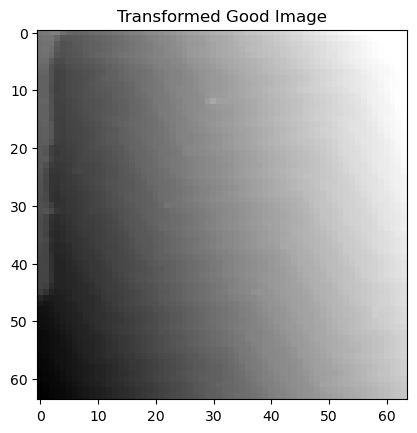

In [4]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import RANSACRegressor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# RANSAC preprocessing for outlier detection and accounting for gradient in plane
class RansacWrapper:
    def __init__(self, sz, th=None):
        self.X = np.zeros((sz*sz, 2))
        if th is None:
            th = 5e-12
        elif th < 0:
            th = None
        for i in range(sz):
            for j in range(sz):
                self.X[i*sz+j][0] = i
                self.X[i*sz+j][1] = j
        self.coords = list(np.ndindex(sz, sz))
        self.ransac = Pipeline(
            [('poly', PolynomialFeatures(degree=1)),
             ('ransac', RANSACRegressor(residual_threshold=th, max_trials=1000))])

    def apply(self, img, params=None):
        sz = img.shape[0]
        y = img.ravel()
        self.ransac.fit(self.X, y)
        plane = self.ransac.predict(self.coords)
        plane.shape = img.shape

        return img - plane

def preprocess_image_with_ransac(img_tensor):
    img_tensor = img_tensor.to(device)  # Ensure tensor is on GPU if available
    img_np = img_tensor.cpu().numpy()  # Move tensor to CPU for NumPy operations
    
    sz = img_np.shape[0]
    ransac_wrapper = RansacWrapper(sz)
    img_processed_np = ransac_wrapper.apply(img_np)
    
    img_processed_tensor = torch.from_numpy(img_processed_np).float().to(device)  # Move back to GPU if available
    
    return img_processed_tensor

# Define the dataset class
class YourDatasetClass(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.valid_data = []  # Store only valid images
        self.valid_labels = []  # Corresponding labels for valid images
        
        # Load examples for the 'bad' and 'good' classes
        for label, label_name in enumerate(['bad', 'good']):
            dir_path = os.path.join(root_dir, label_name)
            count = 0  # Initialize a counter for each class
            for filename in os.listdir(dir_path):
                if filename.endswith('Default.npy') and count < 10000:
                    file_path = os.path.join(dir_path, filename)
                    img = np.load(file_path)
                    if not np.isnan(img).any():  # Exclude images with NaN values
                        self.valid_data.append(file_path)
                        self.valid_labels.append(label)  # Label '0' for 'bad', '1' for 'good'
                        count += 1  # Increment the counter

            print(f"Total number of valid images in the {label_name} dataset after removing NaN values:", count)            

    def __len__(self):
        return len(self.valid_data)

    def __getitem__(self, idx):
        # Load and normalize .npy file
        img_path = self.valid_data[idx]
        img = np.load(img_path)
        min_value = img.min()
        max_value = img.max()
        
        # Check for NaN values and handle them
        if np.isnan(img).any() or min_value == max_value:
            return None, None, None
        
        img = (img - min_value) / (max_value - min_value)
        img = (img * 255).astype('uint8')  # Convert to 8-bit pixel values
        img = Image.fromarray(img, 'L')  # Convert to grayscale image

        # Apply RANSAC preprocessing
        #img_tensor = torch.from_numpy(np.array(img)).float().to(device)  # Move to GPU
        #img_tensor = preprocess_image_with_ransac(img_tensor) 
        #img = Image.fromarray(img_tensor.cpu().numpy().astype('uint8'), 'L')  # Move back to CPU for PIL operations

        label = self.valid_labels[idx]

        original_img = img.copy()

        if self.transform:
            img = self.transform(img)

        return img, original_img, label

    def save_transformed_images(self, output_dir):
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        
        for idx in range(len(self.valid_data)):
            transformed_img, original_img, label = self[idx]
            if transformed_img is not None:
                class_folder = 'good' if label == 1 else 'bad'
                output_path = os.path.join(output_dir, class_folder)
                
                if not os.path.exists(output_path):
                    os.makedirs(output_path)
                
                base_filename = os.path.splitext(os.path.basename(self.valid_data[idx]))[0]
                transformed_img_path = os.path.join(output_path, base_filename + '_transformed.npy')
                original_img_path = os.path.join(output_path, base_filename + '_original.npy')
                
                np.save(transformed_img_path, np.array(transformed_img))
                np.save(original_img_path, np.array(original_img))
                print(f"Saved: {transformed_img_path} and {original_img_path}")

# Data Augmentation
class RandomRotate0or90:
    """Rotates the image by 0 or 90 degrees."""

    def __call__(self, x):
        angle = random.choice([0, 90])  # Choose between 0 or 90 degrees
        return x.rotate(angle)

# Define transformations for your STM images
transform = transforms.Compose([
    RandomRotate0or90(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Grayscale(num_output_channels=1),  # Convert image to grayscale
    transforms.ToTensor(), # Convert to tensor
    transforms.Normalize((0.5,), (0.5,)), # Normalize with mean=0.5 and std=0.5
])

# Instantiate the dataset for training
train_dataset = YourDatasetClass(root_dir=r'C:\Users\Razer\DeepSPM\classifier\FYP complete dataset\train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=24, shuffle=True)

# Instantiate the dataset for test
test_dataset = YourDatasetClass(root_dir=r'C:\Users\Razer\DeepSPM\classifier\FYP complete dataset\test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=24, shuffle=True)

# Check Length of Dataset
print("Total number of valid images in the training dataset:", len(train_dataset))
print("Total number of valid images in the test dataset:", len(test_dataset))

# Save the transformed images to new folders
train_dataset.save_transformed_images(r'C:\Users\Razer\DeepSPM\classifier\FYP complete dataset\transformed_train')
test_dataset.save_transformed_images(r'C:\Users\Razer\DeepSPM\classifier\FYP complete dataset\transformed_test')

# Check a Few Samples from the Dataset
def imshow(img, title=None, is_tensor=False):
    if is_tensor:
        img = img.squeeze(0).numpy()  # Remove the channel dimension and convert to numpy array
    plt.imshow(img, cmap='gray')
    if title:
        plt.title(title)
    plt.show()

# Display information for a mixture of 'good' and 'bad' transformed images
def display_mixed_transformed_images(dataset):
    good_sample_displayed = False
    bad_sample_displayed = False
    
    for i in range(len(dataset)):
        transformed_img, original_img, label = dataset[i]
        if transformed_img is not None:
            if label == 1 and not good_sample_displayed:
                print(f"Good Sample {i+1}:")
                print(f"Label: {label}")
                print(f"Transformed Image shape: {np.array(transformed_img).shape}")
                print(f"Pixel value range: {np.array(transformed_img).min()} - {np.array(transformed_img).max()}")
                imshow(original_img, title="Original Good Image")
                imshow(transformed_img, title="Transformed Good Image", is_tensor=True)
                good_sample_displayed = True
            elif label == 0 and not bad_sample_displayed:
                print(f"Bad Sample {i+1}:")
                print(f"Label: {label}")
                print(f"Transformed Image shape: {np.array(transformed_img).shape}")
                print(f"Pixel value range: {np.array(transformed_img).min()} - {np.array(transformed_img).max()}")
                imshow(original_img, title="Original Bad Image")
                imshow(transformed_img, title="Transformed Bad Image", is_tensor=True)
                bad_sample_displayed = True
            
            if good_sample_displayed and bad_sample_displayed:
                break

# Display a mixture of 'good' and 'bad' transformed images from the training dataset with additional information
display_mixed_transformed_images(train_dataset)

In [5]:
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from collections import Counter
from sklearn.model_selection import train_test_split, StratifiedKFold
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
from torchvision import models
from sklearn.metrics import confusion_matrix
from torch.utils.data import WeightedRandomSampler

class TransformedDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.labels = []

        for label, label_name in enumerate(['bad', 'good']):
            dir_path = os.path.join(root_dir, label_name)
            for filename in os.listdir(dir_path):
                if filename.endswith('_transformed.npy'):
                    file_path = os.path.join(dir_path, filename)
                    self.data.append(file_path)
                    self.labels.append(label)  # Label '0' for 'bad', '1' for 'good'

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        img = np.load(img_path)  # Load the .npy file
        img = Image.fromarray(img.squeeze(0), 'L')  # Convert to grayscale image

        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

# Define transformations for training data with more augmentations
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    transforms.RandomRotation(degrees=45),  # Increased rotation angle
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2),  # Increased range
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define transformations for test data (no augmentation, just normalization)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Instantiate the dataset for training and testing
transformed_train_dataset = TransformedDataset(root_dir=r'C:\Users\Razer\DeepSPM\classifier\FYP complete dataset\transformed_train', transform=train_transform)
transformed_test_dataset = TransformedDataset(root_dir=r'C:\Users\Razer\DeepSPM\classifier\FYP complete dataset\transformed_test', transform=test_transform)

# Split the dataset into training and validation
train_indices, val_indices = train_test_split(np.arange(len(transformed_train_dataset)), test_size=0.2, stratify=transformed_train_dataset.labels)
train_dataset = Subset(transformed_train_dataset, train_indices)
val_dataset = Subset(transformed_train_dataset, val_indices)

# Calculate class weights
def calculate_class_weights(dataset):
    labels = dataset.labels
    label_counts = Counter(labels)
    total_count = len(labels)
    class_weights = {cls: total_count / count for cls, count in label_counts.items()}
    return class_weights

class_weights = calculate_class_weights(transformed_train_dataset)
print("Class Weights:", class_weights)

# Convert class weights to tensor
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class_weight_tensor = torch.FloatTensor([class_weights[0], class_weights[1]]).to(device)

# Create DataLoader objects
batch_size = 16

# Create weighted random sampler for handling class imbalance
class_weights = [class_weight_tensor[0].item(), class_weight_tensor[1].item()]
samples_weights = [0] * len(train_indices)
for idx in range(len(train_indices)):
    class_weight = class_weights[transformed_train_dataset.labels[train_indices[idx]]]
    samples_weights[idx] = class_weight
sampler = WeightedRandomSampler(samples_weights, num_samples=len(samples_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(transformed_test_dataset, batch_size=batch_size, shuffle=False)

# Debugging lines to show batch size used for train, validation, and test loaders
print(f"Batch size for train_loader: {train_loader.batch_size}")
print(f"Batch size for val_loader: {val_loader.batch_size}")
print(f"Batch size for test_loader: {test_loader.batch_size}")

# Check Length of Datasets
print("Total number of images in the transformed training dataset:", len(train_dataset))
print("Total number of images in the transformed validation dataset:", len(val_dataset))
print("Total number of images in the transformed test dataset:", len(transformed_test_dataset))

class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.counter = 0
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decreases.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

# Initialize early stopping
early_stopping = EarlyStopping(patience=5, verbose=True)

model = models.resnet18(weights='IMAGENET1K_V1')
# Modify the final layer for binary classification
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.7),
    nn.BatchNorm1d(num_ftrs),  # Added batch normalization
    nn.Linear(num_ftrs, 1)  # Output one score
)

# Send model to GPU
model.to(device)

# Define Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=class_weight_tensor[1], gamma=3, reduction='mean'):  # Set alpha dynamically
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)  # prevents nans when probability 0
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction == 'mean':
            return F_loss.mean()
        elif self.reduction == 'sum':
            return F_loss.sum()
        else:
            return F_loss

# Initialize Focal Loss with different alpha and gamma
criterion = FocalLoss(alpha=class_weight_tensor[1], gamma=3)  # Adjust gamma as needed

# Adjust optimizer parameters
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)  # Increased learning rate

# Using StepLR for learning rate scheduling
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)  # Adjusted step size and gamma

trainLoss, valLoss, accuracy = [], [], []

num_epochs = 20  # Number of epochs

def threshold_predictions(outputs, threshold=0.5):
    return (torch.sigmoid(outputs) > threshold).float()

best_threshold = 0.5  # Fixed threshold

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1).float())  # Adjust labels' shape

        loss.backward()

        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    all_labels = []
    all_predictions = []
    all_outputs = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            val_loss += loss.item()

            all_outputs.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Apply threshold
            predicted = threshold_predictions(outputs, threshold=best_threshold)
            total += labels.size(0)
            correct += (predicted.flatten() == labels).sum().item()

            # Collect all labels and predictions for metric computation
            all_predictions.extend(predicted.cpu().numpy())

    roc_auc = roc_auc_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions, zero_division=0)
    precision = precision_score(all_labels, all_predictions, zero_division=0)
    recall = recall_score(all_labels, all_predictions, zero_division=0)

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_predictions)
    print(f'Confusion Matrix:\n{cm}')

    epoch_train_loss = train_loss / len(train_loader)
    epoch_val_loss = val_loss / len(val_loader)
    epoch_accuracy = correct / total * 100
    accuracy.append(epoch_accuracy)
    trainLoss.append(epoch_train_loss)
    valLoss.append(epoch_val_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}, Learning Rate: {scheduler.get_last_lr()[0]}, Accuracy: {epoch_accuracy:.2f}%')
    print(f'ROC AUC: {roc_auc:.2f}, F1 Score: {f1:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}')

    # Early stopping
    early_stopping(epoch_val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

    # Scheduler step without epoch argument
    scheduler.step()

    # Save model checkpoint every 5 epochs
    if epoch % 5 == 0:
        torch.save(model.state_dict(), f'model_checkpoint_epoch_{epoch}.pt')

# Load the best model
model.load_state_dict(torch.load('checkpoint.pt'))
print('Training complete')

# Evaluate on test data
model.eval()
test_loss, correct, total = 0.0, 0, 0
all_labels = []
all_predictions = []
all_outputs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1).float())
        test_loss += loss.item()

        all_outputs.extend(outputs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Apply threshold
        predicted = threshold_predictions(outputs, threshold=best_threshold)
        total += labels.size(0)
        correct += (predicted.flatten() == labels).sum().item()

        # Collect all labels and predictions for metric computation
        all_predictions.extend(predicted.cpu().numpy())

test_roc_auc = roc_auc_score(all_labels, all_predictions)
test_f1 = f1_score(all_labels, all_predictions, zero_division=0)
test_precision = precision_score(all_labels, all_predictions, zero_division=0)
test_recall = recall_score(all_labels, all_predictions, zero_division=0)

test_loss /= len(test_loader)
test_accuracy = correct / total * 100

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')
print(f'Test ROC AUC: {test_roc_auc:.2f}, Test F1 Score: {test_f1:.2f}, Test Precision: {test_precision:.2f}, Test Recall: {test_recall:.2f}')

Class Weights: {0: 1.1683475562451513, 1: 6.940092165898617}
Batch size for train_loader: 16
Batch size for val_loader: 16
Batch size for test_loader: 16
Total number of images in the transformed training dataset: 1204
Total number of images in the transformed validation dataset: 302
Total number of images in the transformed test dataset: 474
Confusion Matrix:
[[117 141]
 [ 21  23]]
Epoch 1/20, Training Loss: 0.9460, Validation Loss: 0.7437, Learning Rate: 0.0001, Accuracy: 46.36%
ROC AUC: 0.49, F1 Score: 0.22, Precision: 0.14, Recall: 0.52
Validation loss decreased (inf --> 0.743661).  Saving model ...
Confusion Matrix:
[[103 155]
 [ 18  26]]
Epoch 2/20, Training Loss: 0.9624, Validation Loss: 0.7704, Learning Rate: 0.0001, Accuracy: 42.72%
ROC AUC: 0.50, F1 Score: 0.23, Precision: 0.14, Recall: 0.59
EarlyStopping counter: 1 out of 5
Confusion Matrix:
[[133 125]
 [ 26  18]]
Epoch 3/20, Training Loss: 0.9132, Validation Loss: 0.6396, Learning Rate: 0.0001, Accuracy: 50.00%
ROC AUC: 0.4